In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from scripts.utils import objective

optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/reusm/code/hp_prediction/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

## Load and format data

In [3]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset/cases/'))

static = pd.read_parquet('data/datasets/base_dataset/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)


train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

## Train or load existing model


In [11]:
# control reproducibility
rng_seed = 42
rng = np.random.RandomState(rng_seed)

FEATURE_NAME = (
    [
        f"{signal}_ema_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)


# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(
    f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}'
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / "xgb.json"

model = xgb.XGBClassifier()
if model_file.exists():
    model_file = model.load_model(f"data/models/xgb.json")
else:
    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, train, FEATURE_NAME),
        n_trials=100,
        show_progress_bar=True,
    )

    # get the best hyperparameters
    best_params = study.best_params

    # refit the model with best parameters
    model.fit(train[FEATURE_NAME], train.label, verbose=1)

    # save the model
    model.save_model(model_file)

100217 train samples and 42681 test samples, positive rate = 0.07


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 49. Best value: 0.713668: 100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


## Evaluation

### Train AUC compute 

In [12]:
# get training auc
tpr_list, auc_list, thr_list = [], [], []
tpr_train, auc_train = [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []
fpr = np.linspace(0, 1, 100)

y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
y_train = train["label"].values
fpr_, tpr_, _ = roc_curve(y_train, y_pred)
auc_train = auc(fpr_, tpr_)

tpr_train = np.interp(np.linspace(0, 1, 100), fpr_, tpr_)

### Model's prediction variance

#### Variance estimation by bootstrapping

In [13]:
y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test["label"].values

# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
bootstrapped_scores = []

i_bootstrap = 0
while i_bootstrap < n_bootstraps:
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    i_bootstrap += 1

    fpr_, tpr_, thr_ = roc_curve(y_test[indices], y_pred[indices])
    auc_ = auc(fpr_, tpr_)
    gmean = np.sqrt(tpr_ * (1 - fpr_))
    id_thresh_opt = np.argmax(gmean)
    sensitivity_list.append(tpr_[id_thresh_opt] * 100)
    specificity_list.append((1 - fpr_[id_thresh_opt]) * 100)
    prevalence = np.mean(y_test[indices])
    ppv_list.append(
        100
        * tpr_[id_thresh_opt]
        * prevalence
        / (tpr_[id_thresh_opt] * prevalence + fpr_[id_thresh_opt] * (1 - prevalence))
    )
    npv_list.append(
        100
        * (1 - fpr_[id_thresh_opt])
        * (1 - prevalence)
        / (
            (1 - tpr_[id_thresh_opt]) * prevalence
            + (1 - fpr_[id_thresh_opt]) * (1 - prevalence)
        )
    )

    tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    thr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, thr_))
    auc_list.append(auc_)


In [14]:
# compute mean ROC curve
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thr_list, axis=0)
sensi_mean = np.mean(sensitivity_list)
speci_mean = np.mean(specificity_list)
ppv_mean = np.mean(ppv_list)
npv_mean = np.mean(npv_list)
sensi_std = np.std(sensitivity_list)
speci_std = np.std(specificity_list)
ppv_std = np.std(ppv_list)
npv_std = np.std(npv_list)


In [15]:
# save the ROC curve
df = pd.DataFrame(
    {
        "fpr": fpr,
        "tpr": tpr_mean,
        "tpr_std": tpr_std,
        "threshold": thr_mean,
        "auc": np.round(np.mean(auc_list), 2),
        "auc_std": np.round(pd.Series(auc_list).std(), 2),
        "sensitivity": sensi_mean,
        "sensitivity_std": sensi_std,
        "specificity": speci_mean,
        "specificity_std": speci_std,
        "ppv": ppv_mean,
        "ppv_std": ppv_std,
        "npv": npv_mean,
        "npv_std": npv_std,
    }
)
result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "xgboost_roc.csv"
df.to_csv(roc_results, index=False)

### Plot

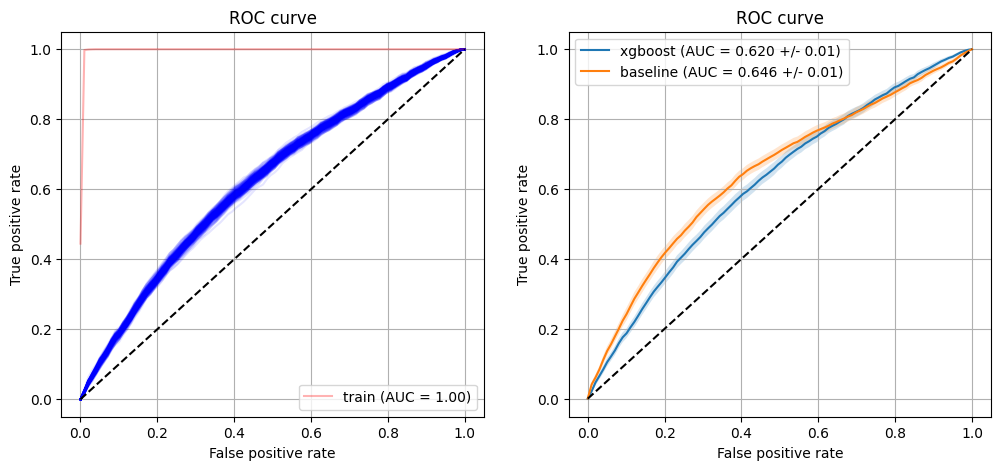

Z-score = -3.52
p-value = 0.00021865025133236497


In [16]:
# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i], 'b', alpha=0.1)
plt.plot(fpr, tpr_train, 'r', alpha=0.3, label=f'train (AUC = {auc_train:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'xgboost (AUC = {np.mean(auc_list):.3f} +/- {pd.Series(auc_list).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/results/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.3f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

Z_score = (np.mean(auc_list) - df_baseline.auc[0])/np.sqrt(df_baseline.auc_std[0]**2 + pd.Series(auc_list).std()**2)
print(f'Z-score = {Z_score:.2f}')
import scipy.stats
p_value = scipy.stats.norm.sf(abs(Z_score)) #one-sided
# p_value = 1 - 0.5*(1 + np.math.erf(Z_score/np.sqrt(2)))
print(f'p-value = {p_value:.20f}')


It seems that the model suffers from extrem overfit (see left figure). The AUC is 100% on the train set.

But on the test, it performs poorly.

Need to add CV for hyper parameters search?

## Others?

The last cell is not used anymore?

TypeError: float() argument must be a string or a real number, not 'NAType'

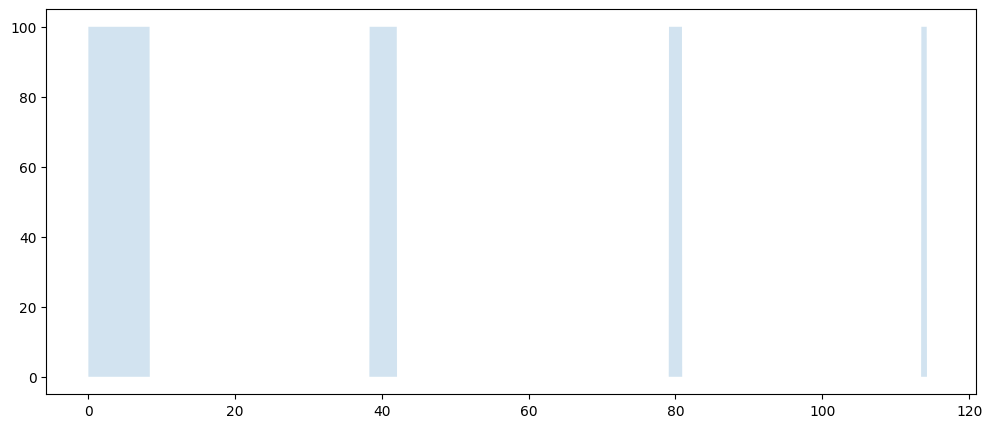

In [10]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)
model = xgb.Booster()
model.load_model(f'data/models/xgb.json')
for case in cases:
    raw_case = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    # raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # # removing the nan values at the beginning and the ending
    # case_valid_mask = ~raw_case.mbp.isna()
    # raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    raw_case.Time = pd.to_timedelta(raw_case.Time, unit="s")
    raw_case.set_index('Time', inplace=True)
    raw_case = raw_case.resample('2s').first()
    raw_case= label_caseid(raw_case, 2)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_pred = model.predict(xgb.DMatrix(x_test))

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot(segment_data[segment_data.label>0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot(segment_data[segment_data.label==0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')
    plt.plot(segment_data.time / np.timedelta64(1, 's') /60, segment_data[f'mbp_ema_10'], '*', label='label')
    plt.xlabel('Time (min)')
    plt.xlim([100, 120])
    # plt.xlim([235, 245])
    plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()

    break



3.0


Time
0 days 01:40:01   NaN
0 days 01:40:03   NaN
0 days 01:40:05   NaN
0 days 01:40:07   NaN
0 days 01:40:09   NaN
0 days 01:40:11   NaN
0 days 01:40:13   NaN
0 days 01:40:15   NaN
0 days 01:40:17   NaN
0 days 01:40:19   NaN
Freq: 2S, Name: label_id, dtype: float64

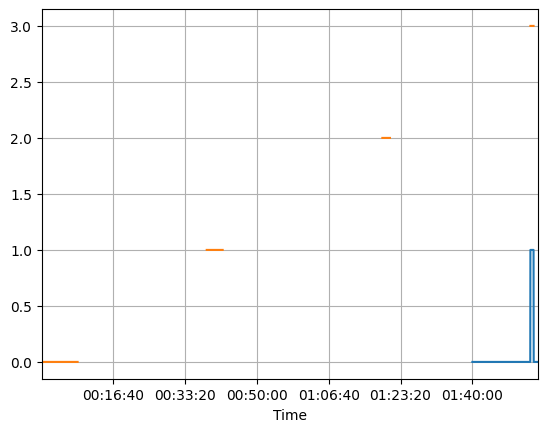

In [ ]:
segmente_pred = raw_case[(raw_case.index.seconds > 100*60) & (raw_case.index.seconds < 120*60)]
segmente_pred.label.plot()
print(segmente_pred.loc[segmente_pred.label.idxmax()].label_id)
raw_case.label_id.plot()
plt.grid()
segmente_pred.iloc[:10]['label_id']